**Máster Universitario en Ciencia de Datos, UAM**
## **Procesamiento del Lenguaje Natural**
# **Práctica de laboratorio 2: Aprendizaje profundo para análisis de sentimientos**


---



Realizado por Pablo Aguilera Onieva

# ***Ejercicio 1 - FFNs***

# Carga y preprocesado de datos - One-hot encoding

In [ ]:
# Montamos el drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Fijamos semillas para generación de números aleatorios
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

np.random.seed(1)
tf.random.set_seed(2)

In [ ]:
import re
import pandas as pd

# Utilizamos el Stanford Sentiment Treebank (SST) como corpus de prueba para análisis de sentimientos de textos
# Cargamos y procesamos los datos para tratarlos como un problema de clasificación binaria de sentimientos
# Convertimos la escala de sentimientos de [1,5] a {0,1}
def load_sst_dataset(file_path, label_map={0:0, 1:0, 2:None, 3:1, 4:1}):
    data = []
    with open(file_path) as f:
        for i, line in enumerate(f):
            instance = {}
            instance['label'] = label_map[int(line[1])]
            if instance['label'] is None:
                continue

            # Filtramos caracteres y etiquetas de parseo
            text = re.sub(r'\s*(\(\d)|(\))\s*', '', line)
            instance['text'] = text[1:]
            data.append(instance)
    data = pd.DataFrame(data)
    return data

#data_folder = 'drive/My Drive/Colab Notebooks/data/'
data_folder = 'data/'

training_set = load_sst_dataset(data_folder + 'sst_training.txt') # conjunto de datos de entrenamiento
validation_set = load_sst_dataset(data_folder + 'sst_validation.txt') # conjunto de datos de validación
test_set = load_sst_dataset(data_folder + 'sst_test.txt') # conjunto de datos de test

print('Instancias de entrenamiento: {}'.format(len(training_set)))
print('Instancias de de validación: {}'.format(len(validation_set)))
print('Instancias de de test: {}'.format(len(test_set)))

Instancias de entrenamiento: 6920
Instancias de de validación: 872
Instancias de de test: 1821


In [ ]:
from tensorflow.keras.preprocessing import text
from sklearn.utils import shuffle

# Desordenamos los conjuntos de datos
training_set = shuffle(training_set)
validation_set = shuffle(validation_set)
test_set = shuffle(test_set)

# Separamos textos y etiquetas de los conjuntos de datos
training_texts = training_set.text
training_labels = training_set.label
validation_texts = validation_set.text
validation_labels = validation_set.label
test_texts = test_set.text
test_labels = test_set.label

# Construimos un índice (vocabulario) para las 1000 palabras más frecuentes en el conjunto de datos de entrenamiento
tokenizer = text.Tokenizer(num_words=1000)
tokenizer.fit_on_texts(training_texts)

print("10 palabras del vocabulario con mayor frecuencia:")
words_index = tokenizer.word_index
for word, index in list(words_index.items())[:10]:
    count = tokenizer.word_counts[word]
    print(f"\t{word}  (índice: {index}, frecuencia: {count})")
print()

sorted_word_counts = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=False)
last_words_counts = sorted_word_counts[:10]
print("10 palabras del vocabulario con menor frecuencia:")
for word, count in last_words_counts:
    index = tokenizer.word_index[word]
    print(f"\t{word}  (índice: {index}, frecuencia: {count})")

10 palabras del vocabulario con mayor frecuencia:
	the  (índice: 1, frecuencia: 5996)
	a  (índice: 2, frecuencia: 4385)
	and  (índice: 3, frecuencia: 3869)
	of  (índice: 4, frecuencia: 3680)
	to  (índice: 5, frecuencia: 2464)
	is  (índice: 6, frecuencia: 2099)
	's  (índice: 7, frecuencia: 2025)
	it  (índice: 8, frecuencia: 1952)
	that  (índice: 9, frecuencia: 1613)
	in  (índice: 10, frecuencia: 1581)

10 palabras del vocabulario con menor frecuencia:
	aid  (índice: 7198, frecuencia: 1)
	milking  (índice: 7199, frecuencia: 1)
	ken  (índice: 7200, frecuencia: 1)
	vacuous  (índice: 7201, frecuencia: 1)
	embody  (índice: 7202, frecuencia: 1)
	nouvelle  (índice: 7203, frecuencia: 1)
	enact  (índice: 7204, frecuencia: 1)
	chapter  (índice: 7205, frecuencia: 1)
	playwright  (índice: 7206, frecuencia: 1)
	drinker  (índice: 7207, frecuencia: 1)


In [ ]:
# Vectorizamos los textos mediante la representación one-hot encoding
x_training = tokenizer.texts_to_matrix(training_texts, mode='binary')
y_training = training_labels
x_validation = tokenizer.texts_to_matrix(validation_texts, mode='binary')
y_validation = validation_labels
x_test = tokenizer.texts_to_matrix(test_texts, mode='binary')
y_test = test_labels

print('Dimensiones del conjunto de entrenamiento: {}'.format(x_training.shape))
print('Dimensiones del conjunto de validación: {}'.format(x_validation.shape))
print('Dimensiones del conjunto de test: {}'.format(x_test.shape))

Dimensiones del conjunto de entrenamiento: (6920, 1000)
Dimensiones del conjunto de validación: (872, 1000)
Dimensiones del conjunto de test: (1821, 1000)


In [ ]:
# Comprobación de algunos vectores generados:
# Iteramos sobre n textos (de entrenamiento) y sus vectores correspondientes
n = 3

index_to_word = tokenizer.index_word # Mapeos de índices a palabras en el vocabulario
word_counts = tokenizer.word_counts # Frecuencias de las palabras en los textos

for i, (text, text_vector) in enumerate(zip(training_texts[:n], x_training[:n]), start=1):
    print(f"Texto {i}: {text}")
    print(f"Vector: {text_vector}")
    print("Palabras:")
    for index, value in enumerate(text_vector):
        # Si el valor en el vector es 1, obtenemos la palabra correspondiente, junto con su índice y frecuencia en el vocabulario
        if value == 1:
            word = index_to_word.get(index)
            word_frequency = word_counts.get(word, 0) if word else 0
            print(f"\t{word} (índice={index}, frecuencia={word_frequency})")
    print()

Texto 1: It is dark , brooding and slow , and takes its central idea way too seriously .
Vector: [0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.

# Construcción de la red

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

input_size = x_training[0].shape[0] # la longitud del vector de entrada es igual al tamaño del vocabulario

# Definimos una red neuronal feedforward con una única capa oculta de 16 unidades
# y ReLU como función de activación
model = Sequential()
model.add(Dense(units=16, activation='relu', input_shape=(input_size,))) # Nota: no es necesario indicar input_shape en capas sucesivas
model.add(Dense(units=1, activation='sigmoid'))

# Compilamos la red usando la entropía cruzada binaria como función de pérdida,
# el algoritmo Adam como optimizador del descenso por gradiente,
# y accuracy como métrica de evaluación en entrenamiento y validación
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Opcionalmente se pueden utilizar otras funciones de activación (e.g., tanh, sigmoid) en vez de ReLU
# y otras funciones de pérdida como mean squared error (MSE)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                16016     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 16,033
Trainable params: 16,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Entrenamos la red durante 100 épocas y con batches de tamaño 32
history = model.fit(x_training, y_training, epochs=100, batch_size=32, validation_data=(x_validation, y_validation), verbose=1)

Epoch 1/100


217/217 [==============================] - 1s 2ms/step - loss: 0.6556 - accuracy: 0.6308 - val_loss: 0.5830 - val_accuracy: 0.7294
Epoch 2/100
217/217 [==============================] - 0s 1ms/step - loss: 0.5298 - accuracy: 0.7600 - val_loss: 0.5116 - val_accuracy: 0.7683
Epoch 3/100
217/217 [==============================] - 0s 1ms/step - loss: 0.4637 - accuracy: 0.7889 - val_loss: 0.4998 - val_accuracy: 0.7511
Epoch 4/100
217/217 [==============================] - 0s 1ms/step - loss: 0.4324 - accuracy: 0.8040 - val_loss: 0.5024 - val_accuracy: 0.7626
Epoch 5/100
217/217 [==============================] - 0s 957us/step - loss: 0.4157 - accuracy: 0.8081 - val_loss: 0.5080 - val_accuracy: 0.7557
Epoch 6/100
217/217 [==============================] - 0s 993us/step - loss: 0.4026 - accuracy: 0.8129 - val_loss: 0.5169 - val_accuracy: 0.7546
Epoch 7/100
217/217 [==============================] - 0s 945us/step - loss: 0.3927 - accuracy: 0.8188 - val_loss: 0.5249 - val_accuracy: 0.7557
Epoch

**Ejercicio 1a - Red de una capa oculta**

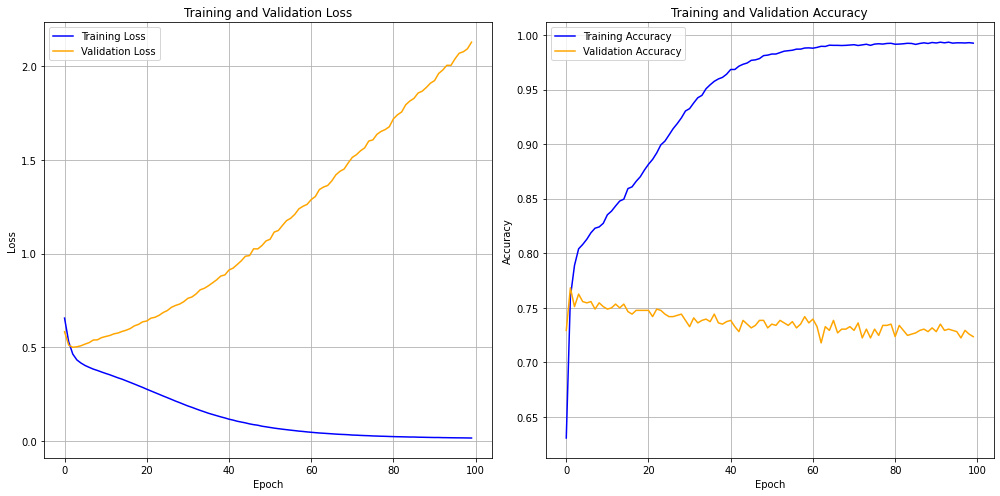

In [ ]:
def visualizar_historial(historia):
    # Obtener los valores de loss y accuracy
    train_loss = historia.history['loss']
    val_loss = historia.history['val_loss']
    train_accuracy = historia.history['accuracy']
    val_accuracy = historia.history['val_accuracy']

    # Crear gráficos para loss y accuracy en una fila
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    # Gráfico de Loss
    axes[0].plot(train_loss, label='Training Loss', color='blue')
    axes[0].plot(val_loss, label='Validation Loss', color='orange')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].grid()
    axes[0].legend()

    # Gráfico de Accuracy
    axes[1].plot(train_accuracy, label='Training Accuracy', color='blue')
    axes[1].plot(val_accuracy, label='Validation Accuracy', color='orange')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].grid()
    axes[1].legend()

    # Ajustar diseño
    plt.tight_layout()
    plt.show()

# Llamamos a la función con el objeto history como argumento
visualizar_historial(history)

El comportamiento de las gráficas de accuracy y loss sugiere que el modelo está experimentando un sobreajuste (overfitting). Esto se evidencia en el aumento de la pérdida de validación a pesar de la disminución o estabilización de la pérdida de entrenamiento y en la disparidad entre la alta precisión de entrenamiento y la precisión más baja de validación.

El modelo aprende a clasificar perfectamente el conjunto de entrenamiento pero no mejora su rendimiento en el conjunto de validación después de un cierto punto. Esto indica que el modelo se ha especializado en el conjunto de entrenamiento y no ha generalizado bien a nuevos datos.

**Ejercicio 1b - Red multicapa**

In [ ]:
# Toma como base el tamaño de entrada del conjunto de entrenamiento
input_size = x_training.shape[1]

# Construye el nuevo modelo FFN con dos capas ocultas
model_2 = Sequential()
model_2.add(Dense(units=16, activation='relu', input_shape=(input_size,)))
model_2.add(Dense(units=16, activation='relu'))  # Capa oculta adicional
model_2.add(Dense(units=1, activation='sigmoid'))  # Capa de salida

# Compila el modelo
model_2.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# Entrena el modelo y guarda la historia de entrenamiento
history_2 = model_2.fit(x_training, y_training,
                        epochs=100,
                        batch_size=32,
                        validation_data=(x_validation, y_validation),
                        verbose=1)

Epoch 1/100
217/217 [==============================] - 1s 2ms/step - loss: 0.6433 - accuracy: 0.6309 - val_loss: 0.5455 - val_accuracy: 0.7546
Epoch 2/100
217/217 [==============================] - 0s 1ms/step - loss: 0.4943 - accuracy: 0.7676 - val_loss: 0.4983 - val_accuracy: 0.7626
Epoch 3/100
217/217 [==============================] - 0s 1ms/step - loss: 0.4244 - accuracy: 0.8051 - val_loss: 0.5039 - val_accuracy: 0.7534
Epoch 4/100
217/217 [==============================] - 0s 1ms/step - loss: 0.3797 - accuracy: 0.8311 - val_loss: 0.5202 - val_accuracy: 0.7523
Epoch 5/100
217/217 [==============================] - 0s 1ms/step - loss: 0.3391 - accuracy: 0.8520 - val_loss: 0.5460 - val_accuracy: 0.7477
Epoch 6/100
217/217 [==============================] - 0s 1ms/step - loss: 0.2926 - accuracy: 0.8766 - val_loss: 0.5769 - val_accuracy: 0.7477
Epoch 7/100
217/217 [==============================] - 0s 1ms/step - loss: 0.2473 - accuracy: 0.8981 - val_loss: 0.6285 - val_accuracy: 0.7408

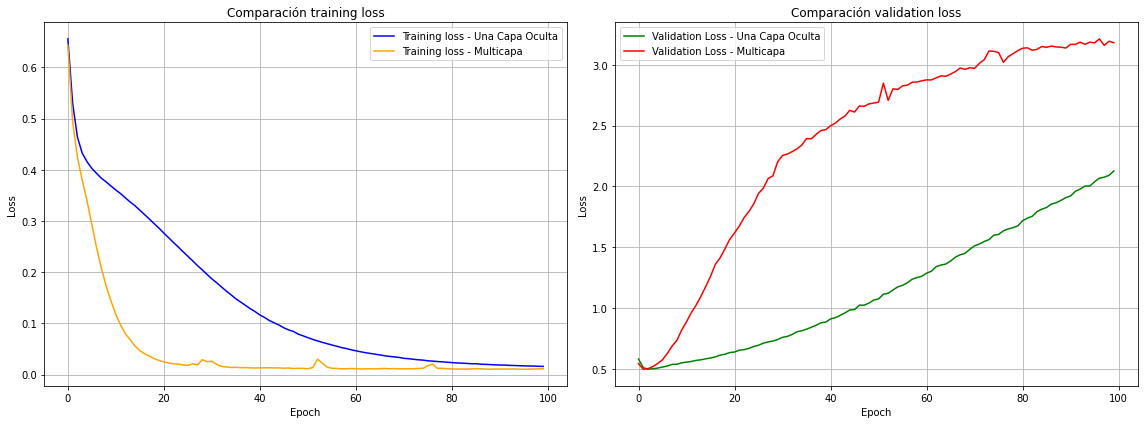

In [ ]:
def visualizar_comparacion_loss(historia, historia_2,label1,label2):
    # Obtener los valores de loss de entrenamiento y validación para ambas redes
    train_loss = historia.history['loss']
    val_loss = historia.history['val_loss']
    train_loss_2 = historia_2.history['loss']
    val_loss_2 = historia_2.history['val_loss']

    # Crear gráficos para loss en una fila
    _, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Gráfico de Loss para una capa oculta
    axes[0].plot(train_loss, label='Training loss - '+label1, color='blue')
    axes[0].plot(train_loss_2, label='Training loss - '+label2, color='orange')
    axes[0].set_title('Comparación training loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid()

    # Gráfico de Loss para dos capas ocultas
    axes[1].plot(val_loss, label='Validation Loss - '+label1, color='green')
    axes[1].plot(val_loss_2, label='Validation Loss - '+label2, color='red')
    axes[1].set_title('Comparación validation loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid()

    # Ajustar diseño
    plt.tight_layout()
    plt.show()

# Llamamos a la función con los objetos history y history_2 como argumentos
visualizar_comparacion_loss(history, history_2,"Una Capa Oculta","Multicapa")

Análisis de Sobreajuste: En ambas redes, el aumento de la pérdida de validación mientras la pérdida de entrenamiento sigue disminuyendo es un indicativo clásico de sobreajuste. El modelo se está volviendo muy bueno para predecir los datos con los que se entrenó, pero esta capacidad no se está traduciendo bien a la predicción de nuevos datos, que es lo que realmente nos interesa.

La inclusión de una capa adicional en la FFN parece no haber tenido un impacto significativo en la prevención del sobreajuste, dado que la tendencia de las curvas de validación es similar en ambos casos. Además, la red de dos capas no parece ofrecer una mejora sustancial en la reducción del loss de validación.

**Ejercicio 1c - Evitando el sobreajuste: early stopping, weight regularization, dropout**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


# Asumimos que la variable 'input_size' está definida correctamente como el número de features de entrada
input_size = x_training.shape[1]

# Construcción de la red
model_c = Sequential([
    Dense(16, activation='relu', input_shape=(input_size,)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilación del modelo
model_c.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Inicialización del Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Entrenamiento del modelo con Early Stopping
history_c = model_c.fit(x_training, y_training,
                        epochs=100,
                        batch_size=32,
                        validation_data=(x_validation, y_validation),
                        callbacks=[early_stopping],
                        verbose=1)


Epoch 1/100
217/217 [==============================] - 1s 2ms/step - loss: 0.6555 - accuracy: 0.6175 - val_loss: 0.5596 - val_accuracy: 0.7420
Epoch 2/100
217/217 [==============================] - 0s 1ms/step - loss: 0.5073 - accuracy: 0.7705 - val_loss: 0.4951 - val_accuracy: 0.7741
Epoch 3/100
217/217 [==============================] - 0s 1ms/step - loss: 0.4399 - accuracy: 0.8016 - val_loss: 0.5016 - val_accuracy: 0.7638
Epoch 4/100
217/217 [==============================] - 0s 1ms/step - loss: 0.4090 - accuracy: 0.8146 - val_loss: 0.5117 - val_accuracy: 0.7638
Epoch 5/100
217/217 [==============================] - 0s 1ms/step - loss: 0.3837 - accuracy: 0.8250 - val_loss: 0.5295 - val_accuracy: 0.7511
Epoch 6/100
217/217 [==============================] - 0s 1ms/step - loss: 0.3544 - accuracy: 0.8423 - val_loss: 0.5419 - val_accuracy: 0.7511
Epoch 7/100
217/217 [==============================] - 0s 1ms/step - loss: 0.3209 - accuracy: 0.8627 - val_loss: 0.5593 - val_accuracy: 0.7592

In [ ]:
from tensorflow.keras import regularizers

# Asumimos que 'input_size' está definida correctamente como el número de características de entrada
input_size = x_training.shape[1]

# Construcción de la red con regularización L2 en las capas ocultas
model_reg = Sequential([
    Dense(16, activation='relu', input_shape=(input_size,),
          kernel_regularizer=regularizers.l2(0.001)),  # Regularización L2
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Regularización L2
    Dense(1, activation='sigmoid')
])

# Compilación del modelo con regularización L2
model_reg.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Entrenamiento del modelo
history_reg = model_reg.fit(x_training, y_training,
                            epochs=100,
                            batch_size=32,
                            validation_data=(x_validation, y_validation),
                            verbose=1)


Epoch 1/100
217/217 [==============================] - 1s 2ms/step - loss: 0.6759 - accuracy: 0.6220 - val_loss: 0.5720 - val_accuracy: 0.7362
Epoch 2/100
217/217 [==============================] - 0s 2ms/step - loss: 0.5349 - accuracy: 0.7646 - val_loss: 0.5379 - val_accuracy: 0.7603
Epoch 3/100
217/217 [==============================] - 0s 1ms/step - loss: 0.4836 - accuracy: 0.7947 - val_loss: 0.5430 - val_accuracy: 0.7603
Epoch 4/100
217/217 [==============================] - 0s 1ms/step - loss: 0.4618 - accuracy: 0.8051 - val_loss: 0.5583 - val_accuracy: 0.7603
Epoch 5/100
217/217 [==============================] - 0s 1ms/step - loss: 0.4485 - accuracy: 0.8150 - val_loss: 0.5666 - val_accuracy: 0.7580
Epoch 6/100
217/217 [==============================] - 0s 1ms/step - loss: 0.4314 - accuracy: 0.8243 - val_loss: 0.5771 - val_accuracy: 0.7580
Epoch 7/100
217/217 [==============================] - 0s 1ms/step - loss: 0.4121 - accuracy: 0.8405 - val_loss: 0.5865 - val_accuracy: 0.7557

In [ ]:
from tensorflow.keras.layers import Dropout
# Asumimos que 'input_size' está definida correctamente como el número de características de entrada
input_size = x_training.shape[1]

# Construcción de la red con Dropout
model_dropout = Sequential([
    Dense(16, activation='relu', input_shape=(input_size,)),
    Dropout(0.5),  # Capa de Dropout con una tasa del 50%
    Dense(16, activation='relu'),
    Dropout(0.5),  # Capa de Dropout con una tasa del 50%
    Dense(1, activation='sigmoid')
])

# Compilación del modelo con Dropout
model_dropout.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Entrenamiento del modelo con Dropout
history_dropout = model_dropout.fit(x_training, y_training,
                                    epochs=100,
                                    batch_size=32,
                                    validation_data=(x_validation, y_validation),
                                    verbose=1)


Epoch 1/100
217/217 [==============================] - 1s 2ms/step - loss: 0.6884 - accuracy: 0.5348 - val_loss: 0.6755 - val_accuracy: 0.5883
Epoch 2/100
217/217 [==============================] - 0s 1ms/step - loss: 0.6566 - accuracy: 0.6007 - val_loss: 0.6070 - val_accuracy: 0.7202
Epoch 3/100
217/217 [==============================] - 0s 1ms/step - loss: 0.5892 - accuracy: 0.6951 - val_loss: 0.5340 - val_accuracy: 0.7534
Epoch 4/100
217/217 [==============================] - 0s 1ms/step - loss: 0.5399 - accuracy: 0.7331 - val_loss: 0.5063 - val_accuracy: 0.7706
Epoch 5/100
217/217 [==============================] - 0s 2ms/step - loss: 0.4950 - accuracy: 0.7714 - val_loss: 0.5010 - val_accuracy: 0.7546
Epoch 6/100
217/217 [==============================] - 0s 1ms/step - loss: 0.4679 - accuracy: 0.7870 - val_loss: 0.4947 - val_accuracy: 0.7683
Epoch 7/100
217/217 [==============================] - 0s 1ms/step - loss: 0.4432 - accuracy: 0.7936 - val_loss: 0.5024 - val_accuracy: 0.7683

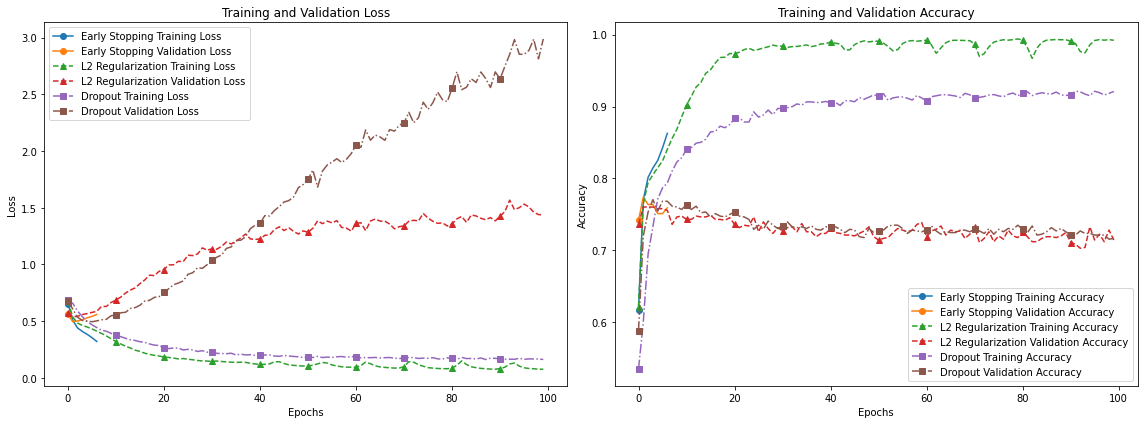

In [ ]:
import matplotlib.pyplot as plt
import itertools

# Define algunos estilos de línea y marcadores para mejorar la legibilidad
line_styles = ['-', '--', '-.', ':']
markers = ['o', '^', 's', 'p', '*', 'x', 'd']

# Función de trazado mejorada
def plot_enhanced_metrics(histories):
    plt.figure(figsize=(16, 6))

    # Estilos de línea y marcadores para cada tipo de línea
    lines = itertools.cycle(line_styles)
    linecycler = itertools.cycle(lines)
    markercycler = itertools.cycle(markers)

    # Subplot para Loss
    plt.subplot(1, 2, 1)
    for name, history in histories.items():
        line = next(linecycler)
        marker = next(markercycler)
        plt.plot(history.history['loss'], line+marker, label=f'{name} Training Loss', markevery=10)
        plt.plot(history.history['val_loss'], line+marker, label=f'{name} Validation Loss', markevery=10)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Subplot para Accuracy
    plt.subplot(1, 2, 2)
    lines = itertools.cycle(line_styles)
    linecycler = itertools.cycle(lines)
    markercycler = itertools.cycle(markers)
    for name, history in histories.items():
        line = next(linecycler)
        marker = next(markercycler)
        plt.plot(history.history['accuracy'], line+marker, label=f'{name} Training Accuracy', markevery=10)
        plt.plot(history.history['val_accuracy'], line+marker, label=f'{name} Validation Accuracy', markevery=10)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

histories = {
'Early Stopping': history_c,
'L2 Regularization': history_reg,
'Dropout': history_dropout
}

plot_enhanced_metrics(histories)


Las gráficas indican que el Early Stopping es efectivo para detener el entrenamiento antes de que el modelo sobreajuste, mientras que la Regularización L2 y el Dropout ayudan a mejorar la generalización del modelo, permitiendo que el entrenamiento continúe por más tiempo sin una pérdida significativa de rendimiento en el conjunto de validación. La precisión en la validación para los modelos con L2 y Dropout muestra que estas técnicas pueden estar ayudando a prevenir el sobreajuste.

Aunque con L2, el loss tanto de vaildación como de entrenamiento se mantienen en valores más o menos reducidos, el Dropout aunque sufre cierta mejora que los valores de usar una multicapa sin métodos de regularización, como se muestra en el siguiente gráfico, sigue manteniendo valores muy malos para el validation loss, esto es debido a que el uso unicamente de la técnica dropout es insuficiente por si sola y puede llegar a añadir ruido.

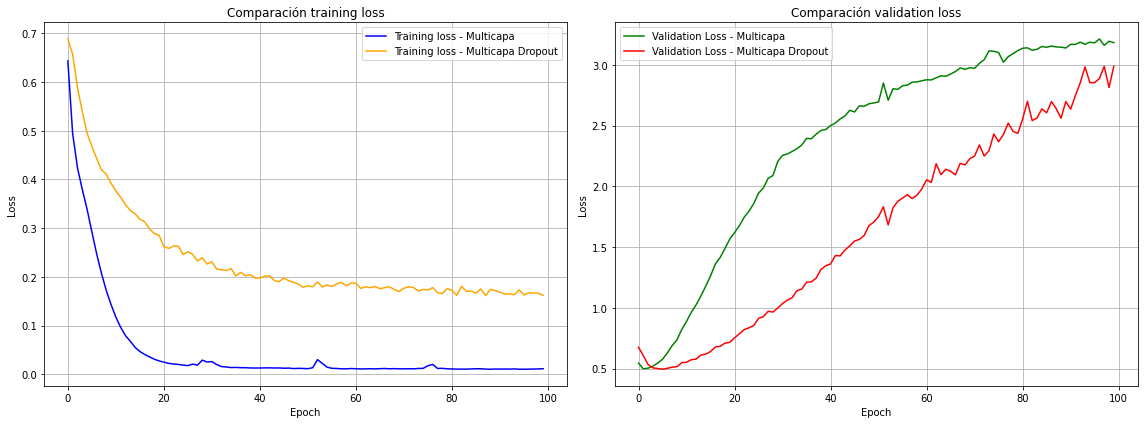

In [ ]:
visualizar_comparacion_loss(history_2, history_dropout,"Multicapa","Multicapa Dropout")

En cuanto a la evaluación en test, se obtienen los siguientes valores:

EarlyStopping:

In [ ]:
model_c.evaluate(x_test,y_test)

57/57 [==============================] - 0s 942us/step - loss: 0.5344 - accuracy: 0.7518


[0.534421443939209, 0.7517847418785095]

Al evaluar este modelo en test, si que se observa datos decentes, loss: 0.49 y accuracy:0.75, esto es debido a que el modelo evita que siga entrenando más allá del punto en el que comienza a sobreajustarse.

L2

In [ ]:
model_reg.evaluate(x_test,y_test)

57/57 [==============================] - 0s 947us/step - loss: 1.3677 - accuracy: 0.7128


[1.367668867111206, 0.7127951383590698]

También se obtienen valores decentes en test aunque peores en la métrica loss, aunque esto puede ser debido simplemente a que el valor de regularización no es el más óptimo.

Dropout

In [ ]:
model_dropout.evaluate(x_test,y_test)

57/57 [==============================] - 0s 1ms/step - loss: 2.3553 - accuracy: 0.7479


[2.355269432067871, 0.747940719127655]

En cuanto a las métricas de test, loss:2.4 y accuracy:0.75, se obtiene una valor de loss muy alto. Esto también se observa en validation. Este dato nos sirve para corroborar lo anteriormente dicho.

**Ejercicio 1d - Evaluación de hiperparámetros mediante grid search**

In [ ]:
from tensorflow.keras.optimizers import Adam

def construir_modelo(learning_rate, dropout_rate, l2_lambda):
    model = Sequential()
    model.add(Dense(units=512, activation='relu', input_shape=(input_size,), kernel_regularizer=regularizers.L2(l2_lambda)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=256, activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=128, activation='relu', kernel_regularizer=regularizers.L2(l2_lambda)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

    return model

In [ ]:
learning_rates = [1e-4, 1e-3, 1e-2]
dropout_rates = [0, 0.2, 0.5]
l2_lambdas = [1e-4]

mejor_accuracy = 0
resultados = []
mejor_epoch=0

for learning_rate in learning_rates:
    for dropout_rate in dropout_rates:
        for l2_lambda in l2_lambdas:
            # Construir el modelo
            model = construir_modelo(learning_rate, dropout_rate, l2_lambda)
            # Entrenar el modelo
            history=model.fit(x_training, y_training, epochs=70, batch_size=32, validation_data=(x_validation, y_validation), verbose=0)
            #Evaluar modelo
            _, precision_test = model.evaluate(x_test, y_test, verbose=0)
            #Ephoc de valor optimo de test en entrenamiento
            for i, acc in enumerate(history.history["accuracy"]):
                if acc >= precision_test:
                    indice = i
                    break
        resultados.append({'best_epoch':indice+1,'best_accuracy':precision_test,'learning_rate': learning_rate, 'dropout_rate': dropout_rate, 'l2_lambda': l2_lambda})


In [ ]:
df_resultados = pd.DataFrame(resultados)

df_resultados.head(9)

,best_epoch,best_accuracy,learning_rate,dropout_rate,l2_lambda
0,3,0.750686,0.0001,0.0,0.0001
1,3,0.747392,0.0001,0.2,0.0001
2,7,0.753432,0.0001,0.5,0.0001
3,2,0.717188,0.0010,0.0,0.0001
4,2,0.727073,0.0010,0.2,0.0001
5,2,0.731466,0.0010,0.5,0.0001
6,2,0.707304,0.0100,0.0,0.0001
7,2,0.715541,0.0100,0.2,0.0001
8,2,0.714443,0.0100,0.5,0.0001


Se observa que el accuracy en test es mayor siempre que la capa Dropout tenga un procentaje igual a 0.5 demostrando que con esa probabilidad de desactivación se consigue un mayor aprendizaje de los datos. Aunque el caso con mayor accuracy en test es cuando las capas Dropout tienen una proporción igual a 0.2 y un learning rate igual a $10^{-4}$. Ese valor de learning rate poseen los valores de grupo más grande, indicando que ese valor para ajustar los pesos de la red neuronal por cada epoch tiene gran ventaja para aumentar la generalización del modelo.

En cuanto al epoch en entrenamiento que se obtiene el valor optimizado de test, se obtienen siempre en las primeras iteraciones. Se ha entendido esta pregunta como cuando entrenamiento se alcanza el valor de accuracy de test. Esto también se ha observado en el resto de casos, con menor velocidad, por lo que se puede determinar que las características de los datos de training se aprenden velozmente.

Para observar esto, se grafica a continuación los valores del mejor modelo en cuanto accuracy en test.

In [ ]:
model_optim=construir_modelo(1e-4,0.2, 1e-4)
history_optim=model_optim.fit(x_training, y_training, epochs=70, batch_size=32, validation_data=(x_validation, y_validation), verbose=0)

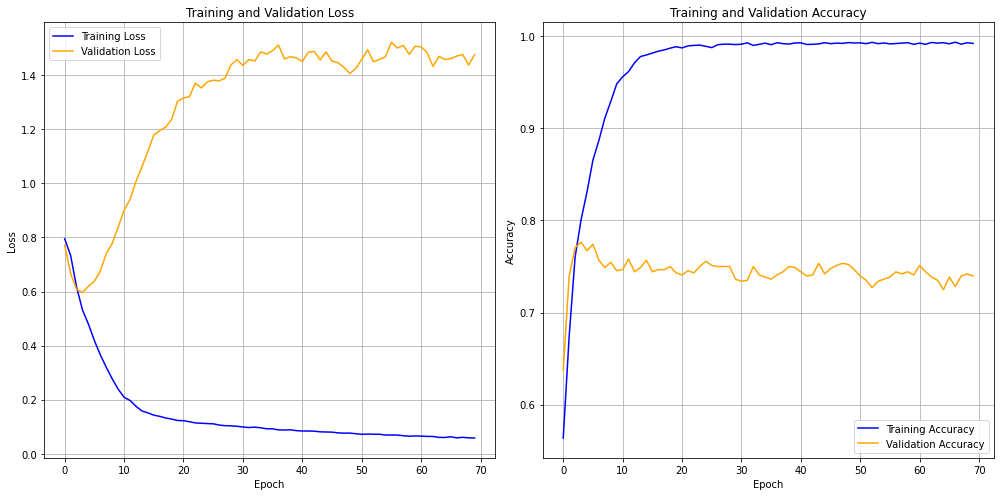

In [ ]:
visualizar_historial(history_optim)

In [ ]:
model_optim.evaluate(x_test,y_test,verbose=1)

57/57 [==============================] - 0s 7ms/step - loss: 1.3372 - accuracy: 0.7452


[1.337170124053955, 0.7451949715614319]

Aunque en test, validación y entrenamiento se obtienen buenos valores en accuracy, se puede observar en los valores de accuracy en validación y entrenamiento en el gráfico, pero en cuanto al valor de loss tanto en test como en validación son muy altos.

Esto puede ser debido el modelo aprende muy bien los detalles y el ruido en los datos de entrenamiento lo que resulta en un rendimiento deficiente en datos nuevos. Esto se viene reflejado a la alta precisión, ya que el modelo está haciendo predicciones precisas pero los valores de perdida son altos. Esto puede ser porque el modelo es demasiado complejo para el conjunto de datos capturando características insignificantes y el ruido de los datos o por otros motivos como el desequilibrio de clases de los datos proporcionados, clasificando de forma errónea las clases minoritarias.

# ***Ejercicio 2 - LSTMs***

# Preprocesado de datos - Tokenization y sequence padding

In [ ]:
from tensorflow.keras import preprocessing

# Creamos un tokenier que considera las 1000 palabras más frecuentes en el corpus
max_words = 10000
tokenizer = preprocessing.text.Tokenizer(num_words=max_words)

# Construimos el índice (diccionario) de palabras a partir del conjunto de datos de entrenamiento
tokenizer.fit_on_texts(training_texts)
word_index = tokenizer.word_index

# Obtenemos los textos como secuencias de enteros
trainining_sequences = tokenizer.texts_to_sequences(training_texts)
validation_sequences = tokenizer.texts_to_sequences(validation_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Padding: convertimos las secuencias de enteros a un tensor 2D de forma (numero_secuencias, longitud_secuencia)
# Con ello igualamos la longitud de las secuencias de entrada
max_seq = 40
x_traininig = preprocessing.sequence.pad_sequences(trainining_sequences, maxlen=max_seq)
x_vadidation = preprocessing.sequence.pad_sequences(validation_sequences, maxlen=max_seq)
x_test = preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_seq)

y_traininig = training_labels
y_vadidation = validation_labels
y_test = test_labels

print('Dimensiones del conjunto de entrenamiento: {}'.format(x_traininig.shape))
print('Dimensiones del conjunto de validación: {}'.format(x_vadidation.shape))
print('Dimensiones del conjunto de test: {}'.format(x_test.shape))

# Visualizamos un par de instancias de entrenamiento
# Asegúrate de que 'training_texts' sea una lista o un DataFrame para poder acceder por índice
print('\nTexto: {}\nVector padded: {}'.format(training_texts[0], x_traininig[0]))
print('\nTexto: {}\nVector padded: {}'.format(training_texts[1], x_traininig[1]))


Dimensiones del conjunto de entrenamiento: (6920, 40)
Dimensiones del conjunto de validación: (872, 40)
Dimensiones del conjunto de test: (1821, 40)

Texto: The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .
Vector padded: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    8    6
  276 2487    3  470    3  234   19 1109  308   72   48  875]

Texto: The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer\/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth .
Vector padded: [   0    0    0    0    0    0    0    0    0    0    0    0    5 1462
 4935    1  648 2121   10  107 2983 7198    6   97 4936    5  196 4937
    2   30 2488   41 1463 1615    4  124 1316   6

# Construcción de la red

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM

embedding_size = 128
lstm_hidden_size = 128

model = Sequential()

# Añadimos una capa de embeddings
# Usamos mask_zero=True para ignorar los token '0' en el padding
# Tras la capa de embeddings, las activaciones tienen la forma (batch_size, max_seq, embedding_size)
model.add(Embedding(max_words, embedding_size, mask_zero=True))

# Añadimos una capa LSTM
model.add(LSTM(lstm_hidden_size))

# Añadimos una capa de salida
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # probar optimizer='rmsprop' en RNN y LSTM
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense_54 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Entrenamos la red durante 20 épocas y con batches de tamaño 128
history_lstm = model.fit(x_traininig, y_traininig, epochs=20, batch_size=128, validation_data=(x_vadidation, y_vadidation), verbose=1)

Epoch 1/20


55/55 [==============================] - 10s 115ms/step - loss: 0.6233 - accuracy: 0.6449 - val_loss: 0.5115 - val_accuracy: 0.7718
Epoch 2/20
55/55 [==============================] - 5s 94ms/step - loss: 0.3346 - accuracy: 0.8714 - val_loss: 0.4631 - val_accuracy: 0.7901
Epoch 3/20
55/55 [==============================] - 5s 97ms/step - loss: 0.1800 - accuracy: 0.9384 - val_loss: 0.5714 - val_accuracy: 0.7890
Epoch 4/20
55/55 [==============================] - 5s 96ms/step - loss: 0.1168 - accuracy: 0.9621 - val_loss: 0.6108 - val_accuracy: 0.7913
Epoch 5/20
55/55 [==============================] - 5s 96ms/step - loss: 0.0637 - accuracy: 0.9801 - val_loss: 0.7440 - val_accuracy: 0.7821
Epoch 6/20
55/55 [==============================] - 5s 97ms/step - loss: 0.0376 - accuracy: 0.9890 - val_loss: 0.8363 - val_accuracy: 0.7729
Epoch 7/20
55/55 [==============================] - 5s 94ms/step - loss: 0.0251 - accuracy: 0.9923 - val_loss: 1.0247 - val_accuracy: 0.7729
Epoch 8/20
55/55 [====

**Ejercicio 2a - LSTM de una capa**

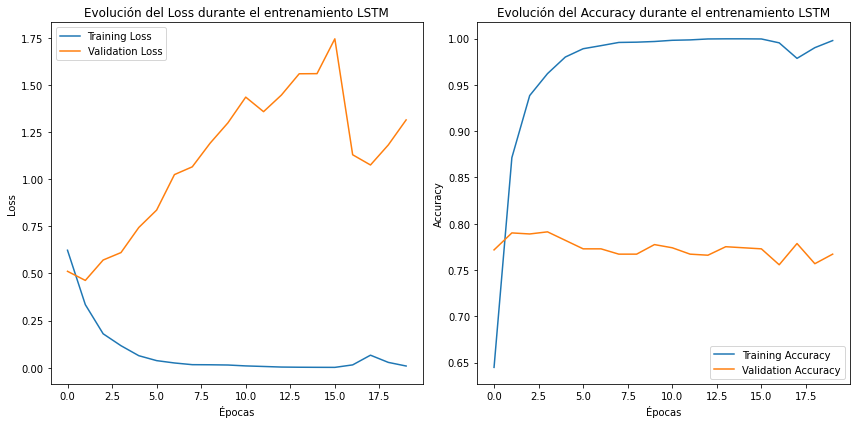

In [ ]:
def plot_history_lstm(history):
    # Gráficas para el Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Evolución del Loss durante el entrenamiento LSTM')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    # Gráficas para el Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Evolución del Accuracy durante el entrenamiento LSTM')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Asegúrate de tener una variable history_lstm con los datos del entrenamiento
# Aquí suponemos que history_lstm ya contiene el historial de entrenamiento
plot_history_lstm(history_lstm)


- El modelo FFN muestra un sobreajuste más claro y marcado que el modelo LSTM. La falta de mejora en la precisión de validación y el aumento constante de la pérdida de validación sugieren que la FFN puede haber aprendido a memorizar los datos de entrenamiento muy eficientemente, lo cual es problemático para la generalización a nuevos datos.
- Aunque ambos modelos parecen luchar con la generalización, los patrones erráticos en la gráfica de LSTM sugieren que podría beneficiarse de más ajustes finos, mientras que la FFN requeriría estrategias de regularización más fuertes para abordar el sobreajuste.
- En términos de tiempos de ejecución, si el entrenamiento del modelo LSTM fue significativamente más largo que el de la FFN, esto podría influir en la elección del modelo, especialmente si la mejora de precisión no justifica el costo computacional adicional.

**Ejercicio 2b - Early stopping**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Configuración del early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

# Entrenamiento del modelo con early stopping
history = model.fit(x_traininig, y_traininig, epochs=100, validation_data=(x_validation, y_validation), callbacks=[early_stopping])


Epoch 1/100


217/217 [==============================] - 17s 80ms/step - loss: 0.0662 - accuracy: 0.9772 - val_loss: 0.9829 - val_accuracy: 0.5092
Epoch 2/100
217/217 [==============================] - 16s 75ms/step - loss: 0.0477 - accuracy: 0.9809 - val_loss: 0.9023 - val_accuracy: 0.5092
Epoch 3/100
217/217 [==============================] - 17s 76ms/step - loss: 0.0158 - accuracy: 0.9955 - val_loss: 2.9764 - val_accuracy: 0.5092
Epoch 4/100
217/217 [==============================] - 16s 75ms/step - loss: 0.0096 - accuracy: 0.9968 - val_loss: 1.7742 - val_accuracy: 0.5092
Epoch 5/100
217/217 [==============================] - 16s 75ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 2.9736 - val_accuracy: 0.5092
Epoch 5: early stopping


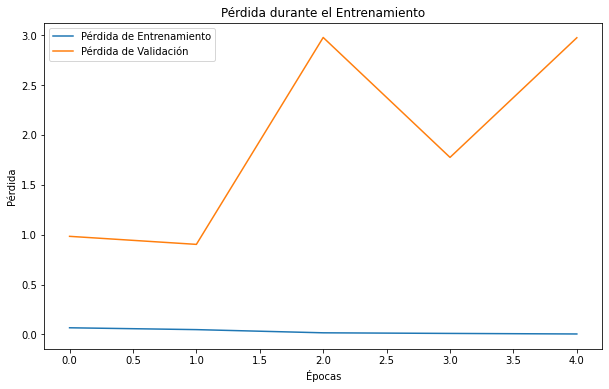

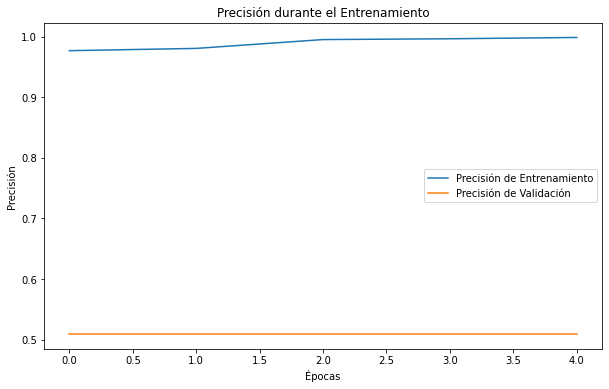

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()


Se nota que el entrenamiento se detiene prematuramente. Esto es exactamente lo que se espera con el uso del early stopping: se detiene el entrenamiento antes de que el modelo se sobreajuste demasiado. En estos gráficos, la pérdida de validación no muestra el mismo incremento significativo después de cierto punto, lo que sugiere que el modelo conserva mejor la capacidad de generalización

**Ejercicio 2c - Tamaño de embeddings y número de unidades LSTM**



In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Definimos los diferentes tamaños de embeddings y unidades LSTM a evaluar
embedding_sizes = [64, 256]  # un tamaño menor y uno mayor
lstm_unit_sizes = [64, 256]  #

# Guardamos el historial de entrenamiento para cada configuración
history_dict = {}

# Iteramos sobre las diferentes configuraciones de tamaño
for embedding_size in embedding_sizes:
    for lstm_units in lstm_unit_sizes:
        model_name = f'emb_{embedding_size}_lstm_{lstm_units}'
        print(f'Entrenando modelo: {model_name}')

        # Construimos el modelo
        model = Sequential()
        model.add(Embedding(max_words, embedding_size, input_length=max_seq, mask_zero=True))
        model.add(LSTM(lstm_units))
        model.add(Dense(1, activation='sigmoid'))

        # Compilamos el modelo
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Entrenamos el modelo
        history = model.fit(x_traininig, y_traininig,
                            epochs=20,  # O el número de épocas que desees
                            batch_size=128,  # O el tamaño de lote que prefieras
                            validation_data=(x_vadidation, y_validation))

        # Guardamos el historial de entrenamiento
        history_dict[model_name] = history.history

        # Asegúrate de limpiar la sesión si estás ejecutando esto en un Jupyter notebook o Google Colab


Entrenando modelo: emb_64_lstm_64
Epoch 1/20
55/55 [==============================] - 7s 62ms/step - loss: 0.6533 - accuracy: 0.6066 - val_loss: 0.5530 - val_accuracy: 0.7557
Epoch 2/20
55/55 [==============================] - 2s 43ms/step - loss: 0.3907 - accuracy: 0.8464 - val_loss: 0.4567 - val_accuracy: 0.7970
Epoch 3/20
55/55 [==============================] - 2s 43ms/step - loss: 0.2123 - accuracy: 0.9236 - val_loss: 0.4884 - val_accuracy: 0.7936
Epoch 4/20
55/55 [==============================] - 2s 45ms/step - loss: 0.1531 - accuracy: 0.9486 - val_loss: 0.5601 - val_accuracy: 0.8005
Epoch 5/20
55/55 [==============================] - 2s 42ms/step - loss: 0.0871 - accuracy: 0.9712 - val_loss: 0.6627 - val_accuracy: 0.7890
Epoch 6/20
55/55 [==============================] - 2s 43ms/step - loss: 0.0564 - accuracy: 0.9827 - val_loss: 0.7892 - val_accuracy: 0.7787
Epoch 7/20
55/55 [==============================] - 2s 45ms/step - loss: 0.0394 - accuracy: 0.9887 - val_loss: 0.9429 - 

In [ ]:
    # Clear the Keras session to free up GPU memory
    from tensorflow.keras import backend as K
    K.clear_session()


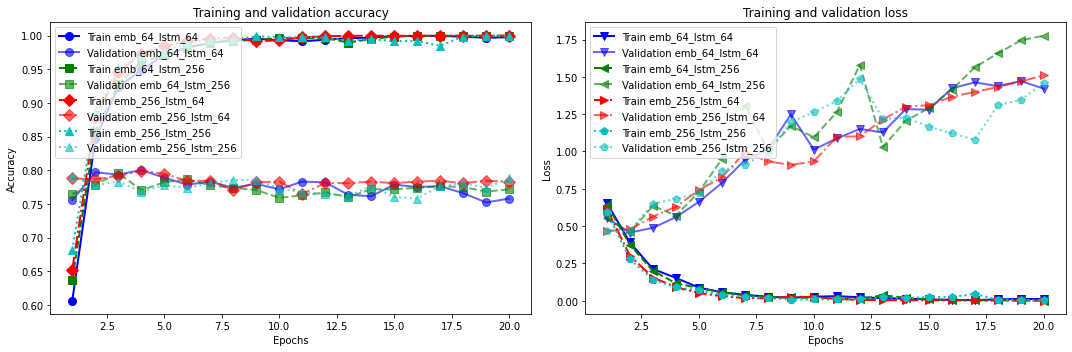

In [ ]:
import matplotlib.pyplot as plt
import itertools

# Define una paleta de colores más amplia
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
# Estilos de línea para cada entrenamiento
line_styles = ['-', '--', '-.', ':']
# Marcadores diferentes para cada validación
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', '+', 'x']

# Crea un iterador cíclico para cada uno para tener una combinación única para cada configuración
color_iter = itertools.cycle(colors)
line_style_iter = itertools.cycle(line_styles)
marker_iter = itertools.cycle(markers)

# Supongamos que 'history_dict' contiene el historial de entrenamiento
def plot_metrics_side_by_side(history_dict):
    metrics = ['accuracy', 'loss']
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1 fila, 2 columnas para nuestros gráficos

    # Iterar sobre cada configuración de métrica y eje
    for ax, metric in zip(axes, metrics):
        # Reset the color iterator for each metric
        color_iter = itertools.cycle(colors)
        for model_name, history in history_dict.items():
            # Get unique color, line style, and marker for each model
            color = next(color_iter)
            line_style = next(line_style_iter)
            marker = next(marker_iter)

            val = history['val_' + metric]
            train = history[metric]
            epochs = range(1, len(val) + 1)

            # Plot training line
            ax.plot(epochs, train, line_style, color=color, marker=marker,
                    label=f'Train {model_name}', linewidth=2, markersize=8)
            # Plot validation line with same color and marker but different line style
            ax.plot(epochs, val, line_style, color=color, marker=marker,
                    label=f'Validation {model_name}', linewidth=2, markersize=8, alpha=0.6)

        ax.set_title(f'Training and validation {metric}')
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric.capitalize())
        ax.legend()

    plt.tight_layout()
    plt.show()

# Llamamos a la función para mostrar los gráficos
plot_metrics_side_by_side(history_dict)


- Inicio de Sobreajuste: Para algunos modelos, el comienzo del sobreajuste es evidente alrededor de la época 10, lo que sugiere que un enfoque de early stopping implementado correctamente podría mejorar la generalización del modelo al detener el entrenamiento antes de que este fenómeno se manifieste completamente.
- Capacidad de Generalización: Aunque los modelos con más unidades LSTM y más dimensiones de embeddings tienen más capacidad para aprender, esto no siempre resulta en un mejor rendimiento en los datos de validación. Es crucial encontrar un equilibrio adecuado entre la capacidad del modelo y la complejidad de los datos.
- Estabilización de la Precisión: A pesar de las fluctuaciones en la pérdida, la precisión de los modelos en el conjunto de validación parece estabilizarse después de cierto punto, lo cual es alentador. Sin embargo, esto no debe tomarse como un signo seguro de un buen modelo sin antes examinar otras métricas de rendimiento, como la pérdida de validación, para obtener una perspectiva más completa

# ***Ejercicio 3 - LSTMs avanzadas***

In [ ]:
def visualizar_comparacion_accuracy(historia, historia_2,label1,label2):
    # Obtener los valores de loss de entrenamiento y validación para ambas redes
    train_loss = historia.history['accuracy']
    val_loss = historia.history['val_accuracy']
    train_loss_2 = historia_2.history['accuracy']
    val_loss_2 = historia_2.history['val_accuracy']

    # Crear gráficos para loss en una fila
    _, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Gráfico de Loss para una capa oculta
    axes[0].plot(train_loss, label='Training accuracy - '+label1, color='blue')
    axes[0].plot(train_loss_2, label='Training accuracy - '+label2, color='orange')
    axes[0].set_title('Comparación training accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('accuracy')
    axes[0].legend()
    axes[0].grid()

    # Gráfico de Loss para dos capas ocultas
    axes[1].plot(val_loss, label='Validation accuracy - '+label1, color='green')
    axes[1].plot(val_loss_2, label='Validation accuracy - '+label2, color='red')
    axes[1].set_title('Comparación validation accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('accuracy')
    axes[1].legend()
    axes[1].grid()

    # Ajustar diseño
    plt.tight_layout()
    plt.show()


**Ejercicio 3a - Stacked LSTMs**

In [ ]:
# Definir el modelo
model_stacked = Sequential()

model_stacked.add(Embedding(max_words, 128, mask_zero=True))
# Primera capa LSTM
model_stacked.add(LSTM(units=128, return_sequences=True))

# Segunda capa LSTM
model_stacked.add(LSTM(units=128))

# Capa de salida
model_stacked.add(Dense(units=1, activation='sigmoid'))

# Compilar el modelo
model_stacked.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history_lstm_stacked = model_stacked.fit(x_traininig, y_traininig, batch_size=128, epochs=10, validation_data=(x_vadidation, y_validation))


Epoch 1/10
55/55 [==============================] - 26s 354ms/step - loss: 0.6075 - accuracy: 0.6610 - val_loss: 0.4708 - val_accuracy: 0.7833
Epoch 2/10
55/55 [==============================] - 26s 466ms/step - loss: 0.2926 - accuracy: 0.8809 - val_loss: 0.4589 - val_accuracy: 0.7844
Epoch 3/10
55/55 [==============================] - 27s 482ms/step - loss: 0.1474 - accuracy: 0.9455 - val_loss: 0.6366 - val_accuracy: 0.7695
Epoch 4/10
55/55 [==============================] - 25s 464ms/step - loss: 0.0909 - accuracy: 0.9695 - val_loss: 0.7888 - val_accuracy: 0.7764
Epoch 5/10
55/55 [==============================] - 25s 457ms/step - loss: 0.0516 - accuracy: 0.9831 - val_loss: 0.8088 - val_accuracy: 0.7787
Epoch 6/10
55/55 [==============================] - 26s 473ms/step - loss: 0.0301 - accuracy: 0.9897 - val_loss: 1.0067 - val_accuracy: 0.7775
Epoch 7/10
55/55 [==============================] - 26s 475ms/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 1.2535 - val_accuracy: 0.7821

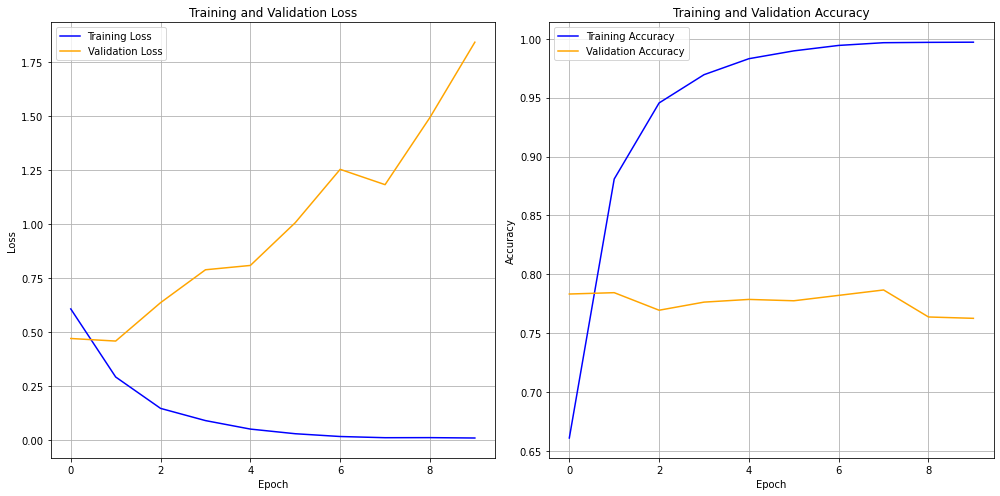

In [ ]:
visualizar_historial(history_lstm_stacked)

Comparando con el uso de una sola capa LSTM, se observa una gran mejora en todos los aspectos. El modelo es capaz de aprender mejor las características y patrones complejos de los datos, por lo que se observa una mejora en la generalización de los datos. La precisión en cuanto a validación se ve muy mejorado y llega a sobreajustarse mucho más lento que la LSTM de una capa. Todo esto con el mismo coste computacional, ya que el coste de tiempo es practicamente igual que al usar una capa LSTM.

En cuanto a utilizar tres capas, se observa una reducción en el loss, pero también una reducción en la precisión en validación y el doble de coste computacional. Esto puede ser debido a la mayor complejidad del modelo en comparación a los datos y su cantidad. Estos aspecto podrían verse mejorados con técnicas de regularización. Y esto se puede observar en las siguientes celdas.

In [ ]:
# Definir el modelo
model_stacked2 = Sequential()

model_stacked2.add(Embedding(max_words, 128, mask_zero=True))
# Primera capa LSTM
model_stacked2.add(LSTM(units=128, return_sequences=True))

# Segunda capa LSTM
model_stacked2.add(LSTM(units=128,return_sequences=True))

# Tercera capa LSTM
model_stacked2.add(LSTM(units=128))

# Capa de salida
model_stacked2.add(Dense(units=1, activation='sigmoid'))

# Compilar el modelo
model_stacked2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history_lstm_stacked2 = model_stacked2.fit(x_traininig, y_traininig, batch_size=128, epochs=10, validation_data=(x_vadidation, y_validation))


Epoch 1/10
55/55 [==============================] - 53s 790ms/step - loss: 0.6234 - accuracy: 0.6389 - val_loss: 0.4877 - val_accuracy: 0.7764
Epoch 2/10
55/55 [==============================] - 43s 781ms/step - loss: 0.3096 - accuracy: 0.8708 - val_loss: 0.4602 - val_accuracy: 0.7867
Epoch 3/10
55/55 [==============================] - 43s 787ms/step - loss: 0.1620 - accuracy: 0.9397 - val_loss: 0.6185 - val_accuracy: 0.7741
Epoch 4/10
55/55 [==============================] - 44s 808ms/step - loss: 0.0936 - accuracy: 0.9678 - val_loss: 0.7434 - val_accuracy: 0.7729
Epoch 5/10
55/55 [==============================] - 42s 763ms/step - loss: 0.0560 - accuracy: 0.9809 - val_loss: 0.9062 - val_accuracy: 0.7603
Epoch 6/10
55/55 [==============================] - 45s 813ms/step - loss: 0.0314 - accuracy: 0.9905 - val_loss: 0.9887 - val_accuracy: 0.7729
Epoch 7/10
55/55 [==============================] - 43s 774ms/step - loss: 0.0182 - accuracy: 0.9941 - val_loss: 1.2273 - val_accuracy: 0.7638

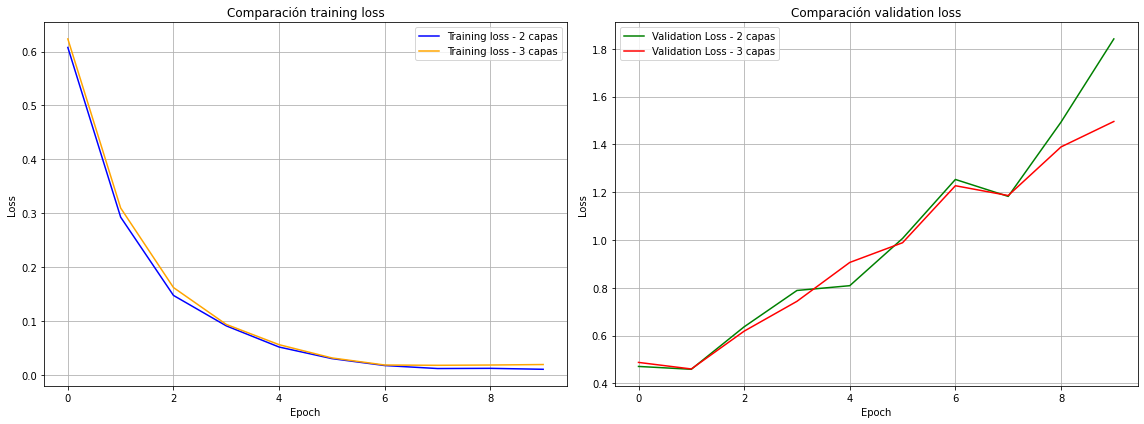

In [ ]:
visualizar_comparacion_loss(history_lstm_stacked,history_lstm_stacked2,"2 capas","3 capas")

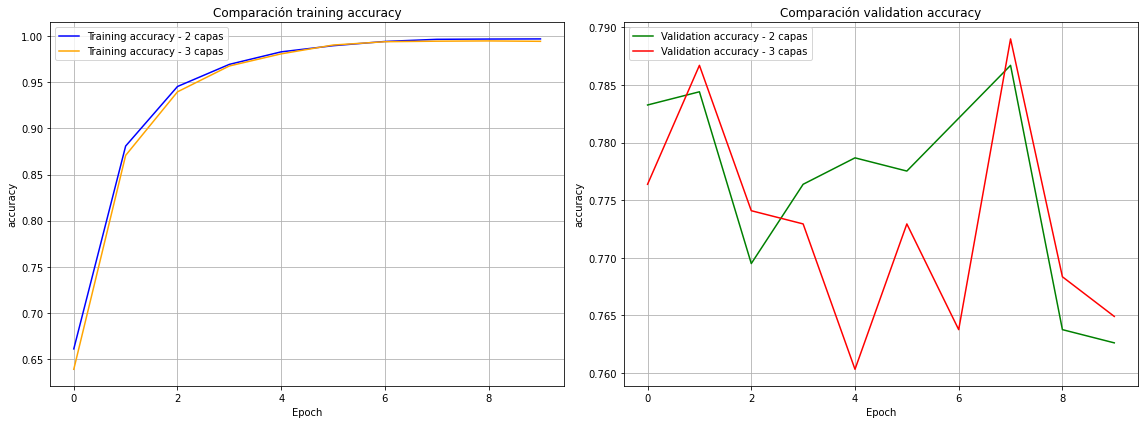

In [ ]:
visualizar_comparacion_accuracy(history_lstm_stacked,history_lstm_stacked2,"2 capas","3 capas")

**Ejercicio 3b - Bidirectional LSTMs**

In [ ]:
from tensorflow.keras.layers import Bidirectional

# Definir el modelo
model_bid= Sequential()

# Capa de embedding
model_bid.add(Embedding(max_words, 128, mask_zero=True))

# Capa Bidirectional LSTM
model_bid.add(Bidirectional(LSTM(units=128)))

# Capa de salida
model_bid.add(Dense(units=1, activation='sigmoid'))

# Compilar el modelo
model_bid.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model_bid.summary()

# Entrenar el modelo
history_lstm_bidirectional = model_bid.fit(x_traininig, y_traininig, batch_size=128, epochs=10, validation_data=(x_vadidation, y_validation))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,543,425
Trainable params: 1,543,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
55/55 [==============================] - 24s 319ms/step - loss: 0.6199 - accuracy: 0.6519 - val_loss: 0.5057 - val_accuracy: 0.7718
Epoch 2/10
55/55 [==============================] - 16s 284ms/step - loss: 0.3231 - accuracy: 0.874

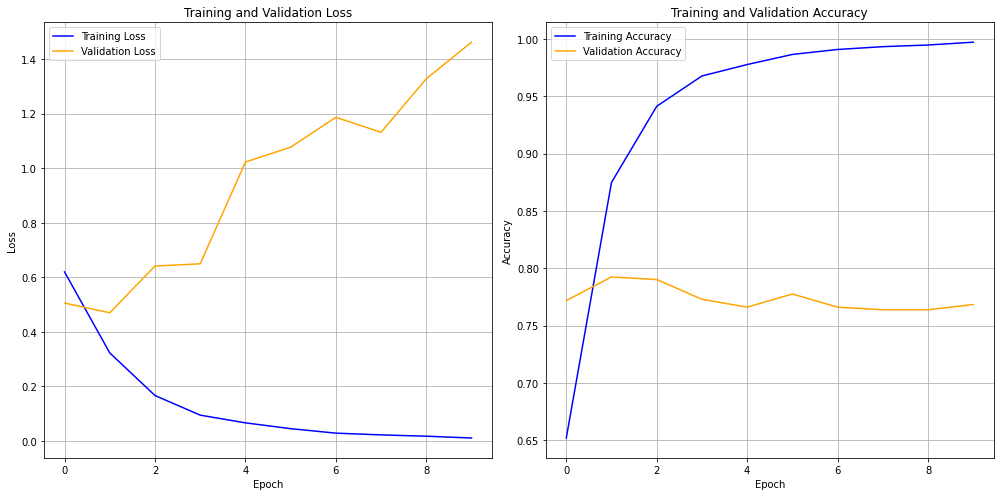

In [ ]:
visualizar_historial(history_lstm_bidirectional)

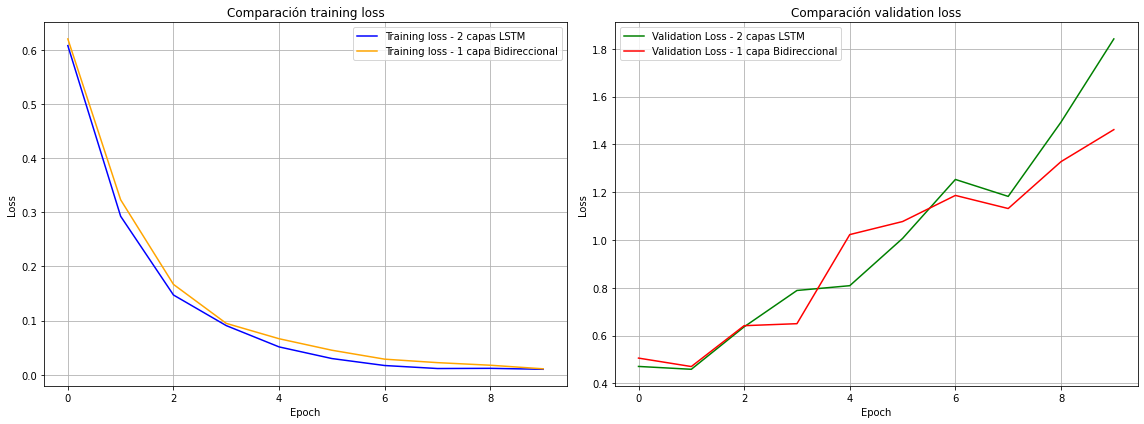

In [ ]:
visualizar_comparacion_loss(history_lstm_stacked,history_lstm_bidirectional,"2 capas LSTM","1 capa Bidireccional")

Se obtiene una gran mejora con el uso de una capa bidireccional respecto con un modelo de dos y tres capas LTSM. Esto es debido a la capacidad de procesar la secuencia de entrada en ambos sentidos, lo que significa que puede capturar mayor la información contextual. Esto ayuda en ciertos problemas como el actual, en una mejora del rendimiento del modelo, en una reducción de la complejidad del modelo y en un mayor aprendizaje del modelo de las características de los datos.

Al añadir una segunda capa bidireccional, a parte de un coste computacional mucho más alto también se produce un empeoramiento del aprendizaje del modelo por la aparición en los epochs más lejano el problema del sobreajuste como se muestra en las celdas siguientes.

In [ ]:
# Definir el modelo
model_bid2= Sequential()

# Capa de embedding
model_bid2.add(Embedding(max_words, 128, mask_zero=True))

# Capa Bidirectional LSTM
model_bid2.add(Bidirectional(LSTM(units=128,return_sequences=True)))

model_bid2.add(Bidirectional(LSTM(units=128)))

# Capa de salida
model_bid2.add(Dense(units=1, activation='sigmoid'))

# Compilar el modelo
model_bid2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model_bid2.summary()

# Entrenar el modelo
history_lstm_bidirectional2 = model_bid2.fit(x_traininig, y_traininig, batch_size=128, epochs=10, validation_data=(x_vadidation, y_validation))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 256)        263168    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,937,665
Trainable params: 1,937,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
55/55 [==========================

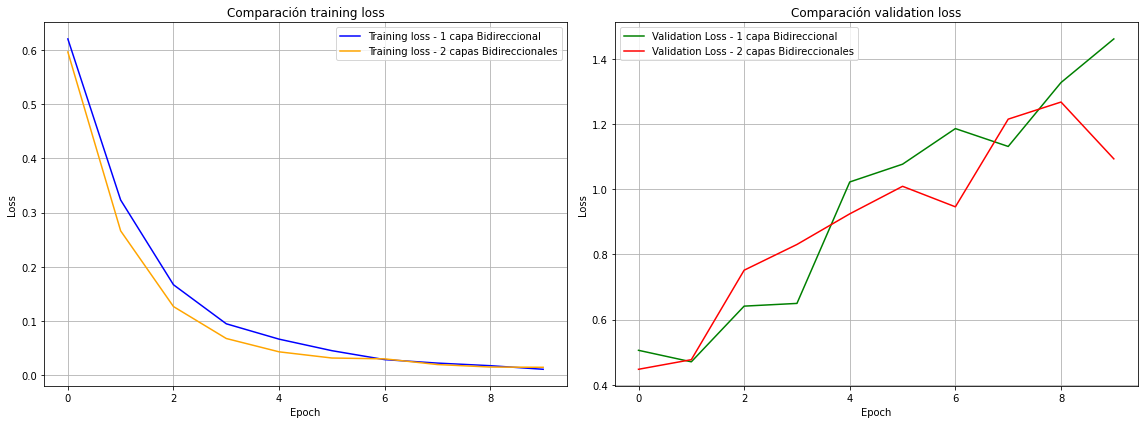

In [ ]:
visualizar_comparacion_loss(history_lstm_bidirectional,history_lstm_bidirectional2,"1 capa Bidireccional", "2 capas Bidireccionales")

# **Ejercicio 4 - Embeddings pre-entrenados: Glove**

**Ejecicio 4a - Carga del fichero y expectativas**

In [ ]:
import bz2
import numpy as np

def cargar_embeddings(ruta_archivo):
    embeddings = {}
    with bz2.open(ruta_archivo, "rt",encoding='utf-8') as f:  # 'rt' significa leer como texto
        for linea in f:
            valores = linea.split()
            palabra = valores[0]
            coefs = np.asarray(valores[1:], dtype='float32')
            embeddings[palabra] = coefs
    return embeddings

# Ruta del archivo comprimido GloVe
#ruta_archivo_glove = "drive/My Drive/Colab Notebooks/data/glove.6B.50d.txt.bz2"
ruta_archivo_glove = "data/glove.6B.50d.txt.bz2"

# Cargar los embeddings
embeddings = cargar_embeddings(ruta_archivo_glove)

# Ejemplo de cómo acceder a los embeddings de una palabra
print(embeddings['computer'])  # Esto imprimirá el vector de embeddings para "computer"


[ 0.079084 -0.81504   1.7901    0.91653   0.10797  -0.55628  -0.84427
 -1.4951    0.13418   0.63627   0.35146   0.25813  -0.55029   0.51056
  0.37409   0.12092  -1.6166    0.83653   0.14202  -0.52348   0.73453
  0.12207  -0.49079   0.32533   0.45306  -1.585    -0.63848  -1.0053
  0.10454  -0.42984   3.181    -0.62187   0.16819  -1.0139    0.064058
  0.57844  -0.4556    0.73783   0.37203  -0.57722   0.66441   0.055129
  0.037891  1.3275    0.30991   0.50697   1.2357    0.1274   -0.11434
  0.20709 ]


## Crear la matriz de embeddings
Vamos a crear una matriz de embeddings que mapea cada índice de palabra a su vector de GloVe.

In [ ]:
dimension_embedding = 50  # Cada vector de GloVe en este ejemplo tiene 50 dimensiones
num_word = len(tokenizer.word_index) + 1
matriz_embeddings = np.zeros((num_word, dimension_embedding))

for palabra, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(palabra)
    if embedding_vector is not None:
        matriz_embeddings[i] = embedding_vector



- Uso de embeddings preentrenados:

  Los embeddings preentrenados ofrecen una representación rica y densa de las palabras, capturando similitudes semánticas y sintácticas. Al usarlos, el modelo puede beneficiarse de un conocimiento previo sobre el lenguaje, lo cual es especialmente útil si se tiene un conjunto de datos pequeño.

- Congelar vs. Ajustar embeddings:

  Congelar los pesos de la capa de embedding significa que no se actualizarán durante el entrenamiento. Esto es útil cuando tienes un pequeño conjunto de datos y quieres evitar el sobreajuste. Sin embargo, si tu conjunto de datos es grande y específico de dominio, podrías optar por ajustar los embeddings junto con el resto de la red para refinarlos en el contexto de tu tarea específica.


**4b - Construir y evaluar LSTMs usando los embeddings cargados. PExplicar brevemente el estudio realizado y discutir los resultados obtenidos**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model_glove = Sequential()
model_glove.add(Embedding(input_dim=num_word, output_dim=dimension_embedding, weights=[matriz_embeddings], trainable=False))
model_glove.add(LSTM(units=100))
model_glove.add(Dense(units=1, activation='sigmoid'))  # Ajusta según tu problema específico

model_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
historial_glove = model_glove.fit(x_traininig, y_traininig, epochs=20, validation_data=(x_vadidation, y_vadidation), verbose=1)

Epoch 1/20


217/217 [==============================] - 10s 38ms/step - loss: 0.6031 - accuracy: 0.6627 - val_loss: 0.5429 - val_accuracy: 0.7282
Epoch 2/20
217/217 [==============================] - 9s 42ms/step - loss: 0.5289 - accuracy: 0.7382 - val_loss: 0.5129 - val_accuracy: 0.7305
Epoch 3/20
217/217 [==============================] - 9s 40ms/step - loss: 0.4987 - accuracy: 0.7527 - val_loss: 0.4872 - val_accuracy: 0.7523
Epoch 4/20
217/217 [==============================] - 11s 50ms/step - loss: 0.4703 - accuracy: 0.7750 - val_loss: 0.4844 - val_accuracy: 0.7569
Epoch 5/20
217/217 [==============================] - 10s 46ms/step - loss: 0.4452 - accuracy: 0.7935 - val_loss: 0.4837 - val_accuracy: 0.7718
Epoch 6/20
217/217 [==============================] - 9s 42ms/step - loss: 0.4231 - accuracy: 0.8014 - val_loss: 0.4606 - val_accuracy: 0.7856
Epoch 7/20
217/217 [==============================] - 9s 43ms/step - loss: 0.4017 - accuracy: 0.8198 - val_loss: 0.4706 - val_accuracy: 0.7775
Epoch 8

In [ ]:
evaluacion = model_glove.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {evaluacion[0]} - Test Accuracy: {evaluacion[1]}")

 1/57 [..............................] - ETA: 1s - loss: 0.6993 - accuracy: 0.7812

57/57 [==============================] - 1s 15ms/step - loss: 0.8684 - accuracy: 0.7617
Test Loss: 0.8683595061302185 - Test Accuracy: 0.761669397354126


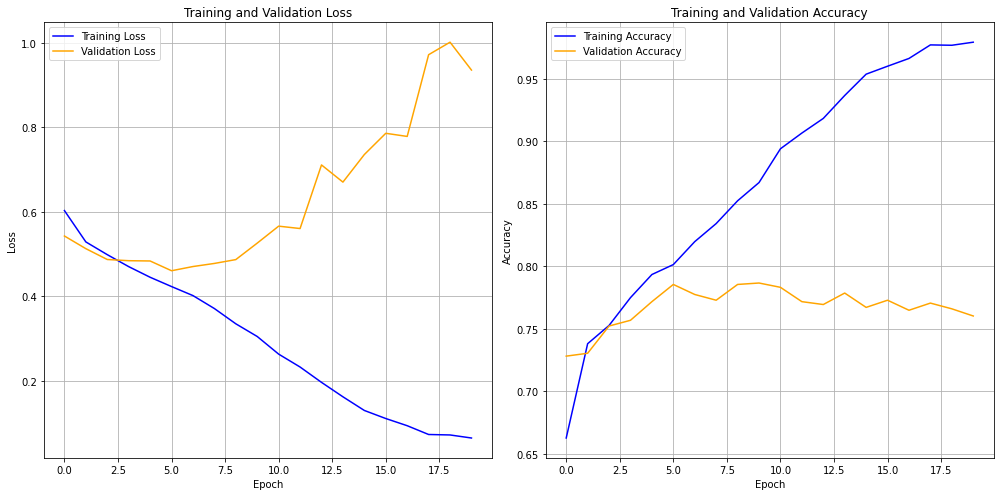

In [ ]:
visualizar_historial(historial_glove)


### Modelo Glove
- Precisión:

La precisión de entrenamiento muestra una tendencia general ascendente a lo largo de las épocas, lo cual es positivo.

La precisión de validación es volátil y no sigue una tendencia clara, lo que sugiere que el modelo no está generalizando de manera consistente.

- Pérdida:

La pérdida de entrenamiento disminuye de manera general, lo cual indica aprendizaje.

La pérdida de validación no muestra una tendencia descendente clara y fluctúa, lo que puede indicar sobreajuste, ya que el modelo mejora en los datos de entrenamiento pero no necesariamente en los de validación.


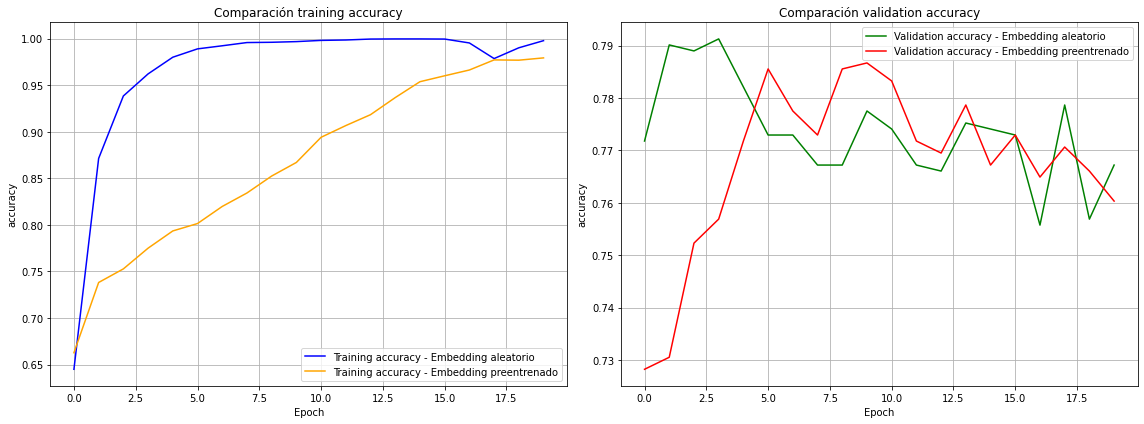

In [ ]:
visualizar_comparacion_accuracy(history_lstm,historial_glove,"Embedding aleatorio","Embedding preentrenado")

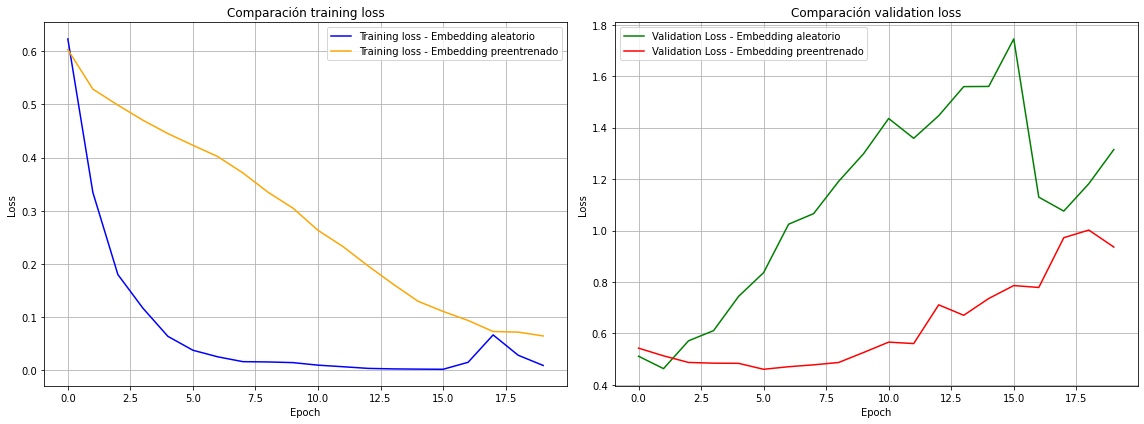

In [ ]:
visualizar_comparacion_loss(history_lstm,historial_glove,"Embedding aleatorio","Embedding preentrenado")

Cumple con las expectativas comentadas en el aparatdo 4a, produciendo una mejora en casi todos los aspecto comparandolo con un embedding aleatorio, reduciendose la velocidad en el que el problema del sobreajutse aparece. Aunque los resultados sean mejores, todavía necesita mucha mejora, como se puede observar en los valores de validation tanto en accuracy y en loss.

**Ejercicio 4c - Evitando el overfitting**

Explorar alguna estrategia (p.ej., dropout) para evitar el sobreajuste de la red. Explicar brevemente lo
observado.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Definimos el modelo con Dropout
model_con_dropout = Sequential()
model_con_dropout.add(Embedding(input_dim=num_word, output_dim=dimension_embedding, weights=[matriz_embeddings], trainable=False))
model_con_dropout.add(LSTM(units=100, return_sequences=False))
model_con_dropout.add(Dropout(0.5))  # Agregamos Dropout del 50%
model_con_dropout.add(Dense(units=1, activation='sigmoid'))  # Asumimos una tarea de clasificación binaria

model_con_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamos el modelo con los mismos datos
historial_dropout = model_con_dropout.fit(x_traininig, y_traininig, epochs=20, validation_data=(x_vadidation, y_vadidation), verbose=1)

Epoch 1/20
217/217 [==============================] - 9s 34ms/step - loss: 0.6125 - accuracy: 0.6607 - val_loss: 0.5487 - val_accuracy: 0.7317
Epoch 2/20
217/217 [==============================] - 9s 40ms/step - loss: 0.5401 - accuracy: 0.7351 - val_loss: 0.5148 - val_accuracy: 0.7477
Epoch 3/20
217/217 [==============================] - 10s 47ms/step - loss: 0.5120 - accuracy: 0.7471 - val_loss: 0.4903 - val_accuracy: 0.7580
Epoch 4/20
217/217 [==============================] - 10s 46ms/step - loss: 0.4901 - accuracy: 0.7636 - val_loss: 0.4868 - val_accuracy: 0.7557
Epoch 5/20
217/217 [==============================] - 10s 46ms/step - loss: 0.4659 - accuracy: 0.7824 - val_loss: 0.4854 - val_accuracy: 0.7649
Epoch 6/20
217/217 [==============================] - 10s 45ms/step - loss: 0.4526 - accuracy: 0.7844 - val_loss: 0.4677 - val_accuracy: 0.7752
Epoch 7/20
217/217 [==============================] - 10s 46ms/step - loss: 0.4406 - accuracy: 0.7951 - val_loss: 0.4636 - val_accuracy: 0

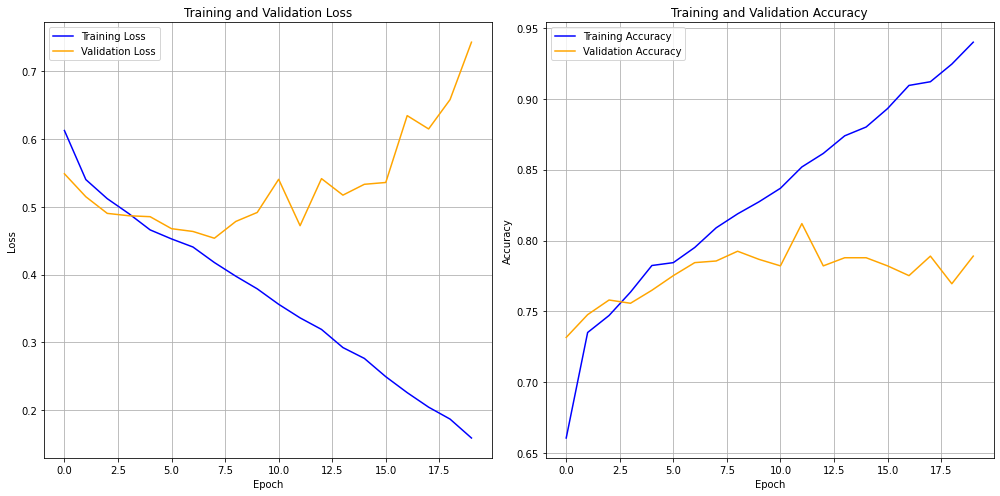

In [ ]:
visualizar_historial(historial_dropout)

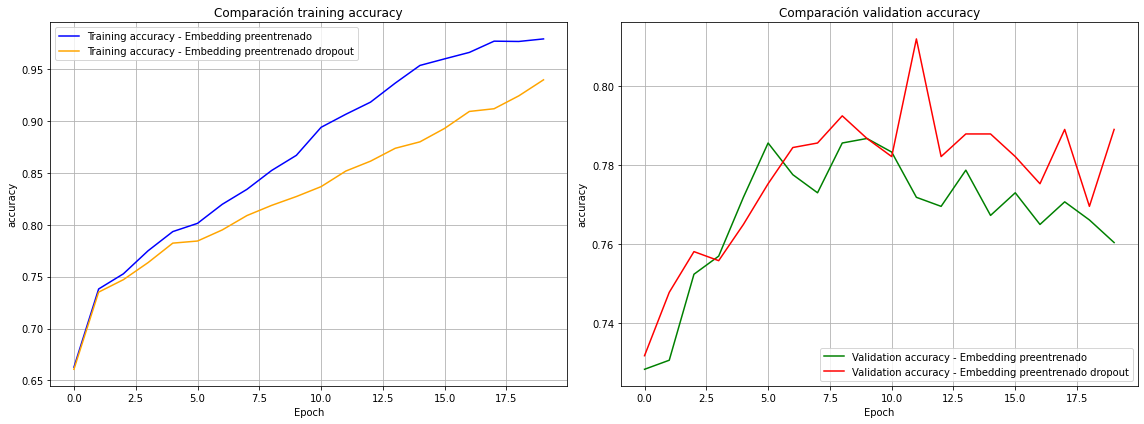

In [ ]:
visualizar_comparacion_accuracy(historial_glove,historial_dropout,"Embedding preentrenado","Embedding preentrenado dropout")

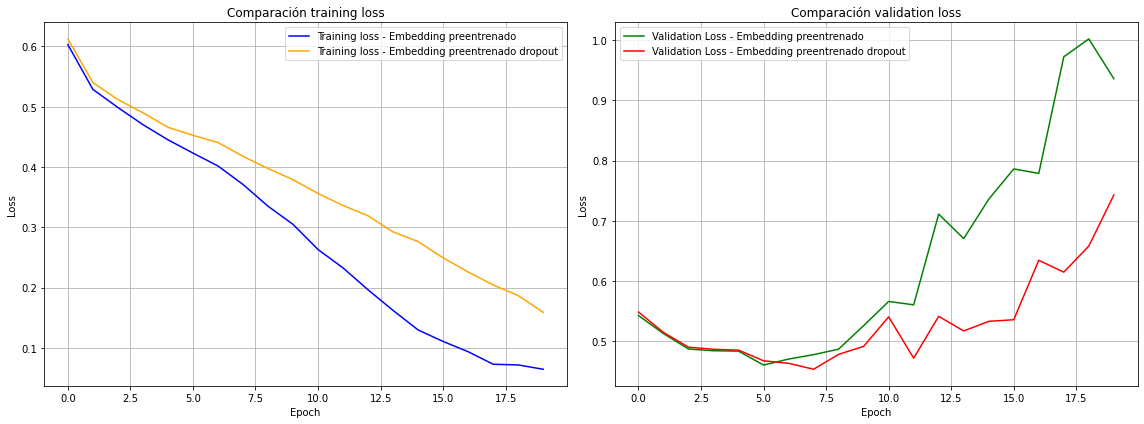

In [ ]:
visualizar_comparacion_loss(historial_glove,historial_dropout,"Embedding preentrenado","Embedding preentrenado dropout")


### Modelo Con Dropout
- Precisión:

La precisión de entrenamiento es ligeramente más baja que la del modelo sin Dropout, lo cual es esperable debido a la regularización impuesta por el Dropout.

La precisión de validación es bastante volátil, al igual que en el modelo sin Dropout, pero se observa que las fluctuaciones se reducen hacia el final del entrenamiento.

- Pérdida:

La pérdida de entrenamiento disminuye, aunque no tan pronunciadamente como sin Dropout, debido a la presencia de regularización.

La pérdida de validación, a pesar de algunas fluctuaciones, muestra una disminución más clara hacia el final del entrenamiento, sugiriendo una mejor generalización en comparación con el modelo sin Dropout.


### Comentario general:

- El modelo con Dropout muestra una mejor tendencia de generalización en términos de pérdida, lo cual es un indicativo de que está comenzando a manejar mejor los datos de validación, y por ende, puede desempeñarse mejor con datos nuevos y no vistos.

- La volatilidad de la precisión en el conjunto de validación sigue siendo un desafío en ambos modelos, con y sin Dropout. Esto puede deberse a la naturaleza de los datos o podría indicar que se necesitan estrategias adicionales para estabilizar el entrenamiento.
- Sobreajuste:
El modelo sin Dropout muestra indicios de sobreajuste más fuertes que el modelo con Dropout, ya que la pérdida de validación no mejora junto con la pérdida de entrenamiento. El Dropout parece mitigar este efecto, como se pretendía.